In [1]:
import os
import sys
import argparse
import torch
from kandev.utils import create_dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
# import logging
import numpy as np
from time import time
from kandev.kan_FFT import *
from matplotlib import pyplot as plt


In [ ]:
def train(model, device, train_loader, valid_loader, optimizer, loss_fn, epoch):
    # global logger
    st = time()
    model.train()
    
    total_train_loss = 0
    preds = []
    labels = []
    for _, (x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = x.to(device),y.to(device)
        output =  model(x)
        loss = loss_fn(output, y) 
        print('output=',output)
        print('y=',y)
                    
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        total_train_loss += loss.item()               
        preds.append(output.detach().cpu())
        labels.append(y.detach().cpu())
    # Concatenate all batches
    preds = torch.cat(preds, dim=0)
    labels = torch.cat(labels, dim=0)
    # tolerance = 0.01
    # train_accuracy = torch.mean((torch.abs(output - y) < tolerance).float())
    train_accuracy=torch.mean(
        ((torch.round(preds*100)/100)==(torch.round(labels*100)/100)).float()
        )
    # logger.info(
    #         "\t **** TRAINING ****   "
    #         f"Epoch [{epoch}], "
    #         f"loss: {total_train_loss:.4f}, "
    #         f"This took {time() - st:.1f} secs.\n"
    #         f"accuracy: {train_accuracy:.2f}, "
    #     )    
    model.eval()
    preds = []
    labels = []
    total_loss_val = 0.0
    with torch.no_grad():
        for _, (x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            output = model(x)
            loss = loss_fn(output, y)      
            total_loss_val += loss.item()
            preds.append(output.detach().cpu())
            labels.append(y.detach().cpu())
        # Concatenate all batches
        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
      
        # val_accuracy = torch.mean((torch.abs(output - y) < tolerance).float())
        val_accuracy=torch.mean(
            ((torch.round(preds*100)/100)==(torch.round(labels*100)/100)).float()
            )
        # logger.info(
        #         "\t **** TESTING ****   "
        #         f"Epoch [{epoch}], "
        #         f"loss: {total_loss_val:.4f}, "
        #         f"accuracy: {val_accuracy:.2f}, "
        #     ) 
    print(f"Epoch {epoch} | Train Loss: {total_train_loss:.6f} | Vali Loss: {total_loss_val:.6f} | Train Acc: {train_accuracy:.2f} | Vali Acc: {val_accuracy:.2f}")
    return total_train_loss, total_loss_val, train_accuracy.item(), val_accuracy.item()


The code uses GPU...


Epoch 1 | Train Loss: 5.460832 | Vali Loss: 4.315987 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 2 | Train Loss: 4.641245 | Vali Loss: 3.884532 | Train Acc: 0.00 | Vali Acc: 0.00
New best Accuracy : 0.00500
Epoch 3 | Train Loss: 4.130271 | Vali Loss: 3.601735 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 4 | Train Loss: 3.772850 | Vali Loss: 3.375557 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 5 | Train Loss: 3.444295 | Vali Loss: 3.151018 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 6 | Train Loss: 3.168901 | Vali Loss: 2.982663 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 7 | Train Loss: 2.988956 | Vali Loss: 2.789903 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 8 | Train Loss: 2.809337 | Vali Loss: 2.599402 | Train Acc: 0.01 | Vali Acc: 0.00
Epoch 9 | Train Loss: 2.610357 | Vali Loss: 2.470426 | Train Acc: 0.00 | Vali Acc: 0.01
New best Accuracy : 0.01000
Epoch 10 | Train Loss: 2.431217 | Vali Loss: 2.371741 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 11 | Train Loss: 2.272526 | Vali Loss: 2.238990 | Train A

<Figure size 640x480 with 0 Axes>

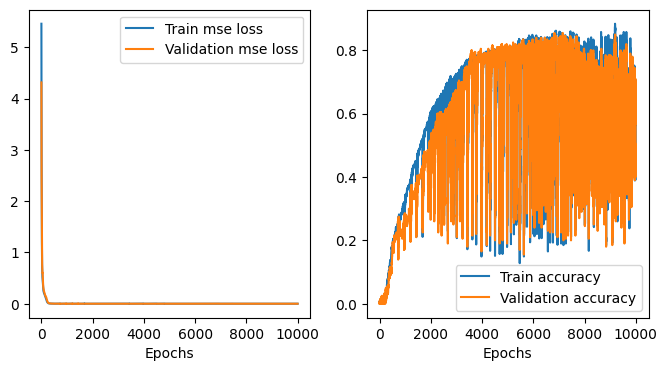

In [3]:
# parser = argparse.ArgumentParser()
# parser.add_argument(
#     'KAN_layers_nodes', type=list,
#     help='Number of nodes in each layer of the KAN model, e.g. [in_dim, hidden_dim, out_dim].'
# )
# parser.add_argument(
#     'KAN_layers_grids', type=list,
#     help='Number of intervals in FFT in the KAN model FFT layer.'
# )

if __name__ == '__main__':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('The code uses GPU...')
    else:
        device = torch.device('cpu')
        print('The code uses CPU!!!')
    
    # # parse arguments
    # # args = parser.parse_args()
    # # setup logging
    # logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

    # logger = logging.getLogger(f"KAN_FFT")
    # logger.setLevel(logging.INFO)
    log_dir = os.getcwd()+'/log'
    os.makedirs(log_dir,exist_ok=True)
    # # Suppress Matplotlib DEBUG logs
    # logging.getLogger("matplotlib").setLevel(logging.WARNING)
    # # Create a file handler to save logs to a file
    # file_handler = logging.FileHandler(os.path.join(log_dir, 'FFTKAN_logfile.log'))
    # # Create a formatter and add it to the handlers
    # formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # file_handler.setFormatter(formatter)
    # #Add the handlers to the logger
    # logger.addHandler(file_handler)


    ## Create dataset
    # f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2+x[:, [0]]**x[:, [1]])
    f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2)
    dataset = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
    dataset1 = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
 
    train_ds = TensorDataset(dataset['train_input'], dataset['train_label'])
    val_ds = TensorDataset(dataset['test_input'], dataset['test_label'])
    test_ds = TensorDataset(dataset1['test_input'], dataset1['test_label'])
    train_loader = DataLoader(train_ds, batch_size=32768, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32768, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=32768, shuffle=False)

    model = KAN_FFT_naive([2,5,1], 12).to(device)
    # model = KAN_FFT(args.KAN_layers_nodes, args.KAN_layers_grids).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)    
    loss_fn = torch.nn.MSELoss()
    
    train_loss_history=[]
    val_loss_history=[]
    train_accuracy_history = []
    val_accuracy_history = []
    
    torch.cuda.reset_peak_memory_stats()
    st=time()
    best_acc = 0
    NUM_EPOCHS=10000
    for epoch in range(NUM_EPOCHS):
        train_loss, val_loss, train_acc, val_acc = train(model, 
                                                         device, 
                                                         train_loader, 
                                                         val_loader, 
                                                         optimizer, 
                                                         loss_fn, 
                                                         epoch + 1)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_acc)
        val_accuracy_history.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            print(f'New best Accuracy : {best_acc:.5f}')
            torch.save(model.state_dict(), 'log/FFt_model.pth')
            
        if val_acc == 1:
            break
    print("Training time (sec):",time()-st)
    print("Best validation accuracy=",best_acc*100,'%')
    plt.clf()
    f,ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(train_loss_history,label='Train mse loss')
    ax[0].plot(val_loss_history,label='Validation mse loss')
    ax[0].set_xlabel("Epochs")
    ax[0].legend()
    
    ax[1].plot(train_accuracy_history,label='Train accuracy')
    ax[1].plot(val_accuracy_history,label='Validation accuracy')
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.savefig('log/plot_train_KANFFT.png')


The code uses GPU...
Epoch 1 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 2 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 3 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 4 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 5 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 6 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 7 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 8 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 9 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 10 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 11 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 12 | Train Loss: nan | Vali Loss: nan | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 13 | Train Loss: nan | Vali Loss: 

<Figure size 640x480 with 0 Axes>

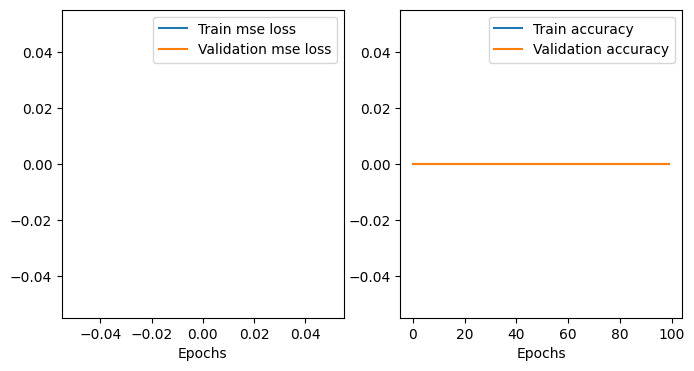

In [4]:
if __name__ == '__main__':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('The code uses GPU...')
    else:
        device = torch.device('cpu')
        print('The code uses CPU!!!')
    
    log_dir = os.getcwd()+'/log'
    os.makedirs(log_dir,exist_ok=True)

    ## Create dataset
    # f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2+x[:, [0]]**x[:, [1]])
    # f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2)
    # f = lambda x: x[:, [0]]*x[:, [1]] + x[:, [0]]**x[:, [1]]
    f = lambda x: x[:, [0]]*x[:, [1]] 
    dataset = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
    dataset1 = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
 
    train_ds = TensorDataset(dataset['train_input'], dataset['train_label'])
    val_ds = TensorDataset(dataset['test_input'], dataset['test_label'])
    test_ds = TensorDataset(dataset1['test_input'], dataset1['test_label'])
    train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

    # x_mean, x_std, y_mean, y_std =  compute_normalization(train_loader)
    model = KAN_FFT([[2,0,0],[5,1,1],[1,0,0]], 12).to(device)
    # model = KAN_FFT([2,5,1], 12).to(device)
    # model = KAN_FFT(args.KAN_layers_nodes, args.KAN_layers_grids).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)    
    loss_fn = torch.nn.MSELoss()
    
    train_loss_history=[]
    val_loss_history=[]
    train_accuracy_history = []
    val_accuracy_history = []
    
    torch.cuda.reset_peak_memory_stats()
    st=time()
    best_acc = 0
    NUM_EPOCHS=100
    for epoch in range(NUM_EPOCHS):
        train_loss, val_loss, train_acc, val_acc = train(model, 
                                                         device, 
                                                         train_loader, 
                                                         val_loader, 
                                                         optimizer, 
                                                         loss_fn, 
                                                         epoch + 1
        )
                                                        #  x_mean, x_std, y_mean, y_std)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_acc)
        val_accuracy_history.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            print(f'New best Accuracy : {best_acc:.5f}')
            torch.save(model.state_dict(), 'log/testFFt_mult_model.pth')
            
        if val_acc == 1:
            break
    print("Training time (sec):",time()-st)
    print("Best validation accuracy=",best_acc*100,'%')
    plt.clf()
    f,ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(train_loss_history,label='Train mse loss')
    ax[0].plot(val_loss_history,label='Validation mse loss')
    ax[0].set_xlabel("Epochs")
    ax[0].legend()
    
    ax[1].plot(train_accuracy_history,label='Train accuracy')
    ax[1].plot(val_accuracy_history,label='Validation accuracy')
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.savefig('log/plot_train_KANFFT_mult.png')


In [12]:
# f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2)
# f = lambda x: torch.exp(x[:, [0]]*x[:, [1]] + x[:, [0]]**x[:, [1]])
f = lambda x: x[:, [0]]*x[:, [1]] + x[:, [0]]**x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
torch.max(dataset['train_input']),torch.min(dataset['train_input'])
   

(tensor(0.9997, device='cuda:0'), tensor(-0.9998, device='cuda:0'))

Trying to increase layers

In [5]:
from kandev.kan_FFT import *

# parser = argparse.ArgumentParser()
# parser.add_argument(
#     'KAN_layers_nodes', type=list,
#     help='Number of nodes in each layer of the KAN model, e.g. [in_dim, hidden_dim, out_dim].'
# )
# parser.add_argument(
#     'KAN_layers_grids', type=list,
#     help='Number of intervals in FFT in the KAN model FFT layer.'
# )

if __name__ == '__main__':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('The code uses GPU...')
    else:
        device = torch.device('cpu')
        print('The code uses CPU!!!')
    
    # # parse arguments
    # # args = parser.parse_args()
    # # setup logging
    # logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

    # logger = logging.getLogger(f"KAN_FFT")
    # logger.setLevel(logging.INFO)
    log_dir = os.getcwd()+'/log'
    os.makedirs(log_dir,exist_ok=True)
    # # Suppress Matplotlib DEBUG logs
    # logging.getLogger("matplotlib").setLevel(logging.WARNING)
    # # Create a file handler to save logs to a file
    # file_handler = logging.FileHandler(os.path.join(log_dir, 'FFTKAN_logfile.log'))
    # # Create a formatter and add it to the handlers
    # formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # file_handler.setFormatter(formatter)
    # #Add the handlers to the logger
    # logger.addHandler(file_handler)


    ## Create dataset
    # f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2+x[:, [0]]**x[:, [1]])
    f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2)
    dataset = create_dataset(f, n_var=2, train_num=50000, test_num=2000, device=device)
    dataset1 = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
 
    train_ds = TensorDataset(dataset['train_input'], dataset['train_label'])
    val_ds = TensorDataset(dataset['test_input'], dataset['test_label'])
    test_ds = TensorDataset(dataset1['test_input'], dataset1['test_label'])
    train_loader = DataLoader(train_ds, batch_size=2**16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=2**16, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=2**16, shuffle=False)

    model = KAN_FFT([2,5,2,1], 4).to(device)
    # model = KAN_FFT(args.KAN_layers_nodes, args.KAN_layers_grids).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)    
    loss_fn = torch.nn.MSELoss()
    
    train_loss_history=[]
    val_loss_history=[]
    train_accuracy_history = []
    val_accuracy_history = []
    
    torch.cuda.reset_peak_memory_stats()
    st=time()
    best_acc = 0
    NUM_EPOCHS=10000
    for epoch in range(NUM_EPOCHS):
        train_loss, val_loss, train_acc, val_acc = train(model, 
                                                         device, 
                                                         train_loader, 
                                                         val_loader, 
                                                         optimizer, 
                                                         loss_fn, 
                                                         epoch + 1)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_acc)
        val_accuracy_history.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            print(f'New best Accuracy : {best_acc:.5f}')
            torch.save(model.state_dict(), 'log/FFt_model.pth')
            
        if val_acc == 1:
            break
    print("Training time (sec):",time()-st)
    print("Best validation accuracy=",best_acc*100,'%')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel()} parameters")
    print('Model has ', print(sum(p.numel() for p in model.parameters() if p.requires_grad)), ' params.')
    plt.clf()
    f,ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(train_loss_history,label='Train mse loss')
    ax[0].plot(val_loss_history,label='Validation mse loss')
    ax[0].set_xlabel("Epochs")
    ax[0].legend()
    
    ax[1].plot(train_accuracy_history,label='Train accuracy')
    ax[1].plot(val_accuracy_history,label='Validation accuracy')
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.savefig('log/plot_train_KANFFT.png')


The code uses GPU...


NameError: name 'train' is not defined

In [4]:
## Test unseen data
tolerance = 0.01
total_loss_test = 0
preds=[]
labels=[]
model = KAN_FFT([2,5,1], 12).to(device)  # same model class as training
model.load_state_dict(torch.load('log/FFt_model.pth')) # Load best accuracy model
model.eval()  # set to evaluation mode if doing inference

with torch.no_grad():
    for _, (x,y) in enumerate(test_loader):
        x,y = x.to(device),y.to(device)
        output = model(x)
        loss = loss_fn(output, y)      
        total_loss_test += loss.item()
        preds.append(output.detach().cpu())
        labels.append(y.detach().cpu())
        # Concatenate all batches
        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
      
    # val_accuracy = torch.mean((torch.abs(output - y) < tolerance).float())
    test_accuracy=torch.mean(
        ((torch.round(preds*100)/100)==(torch.round(labels*100)/100)).float()
        )
    test_accuracy_tol = torch.mean((torch.abs(preds - labels) < tolerance).float())
    print(f"Test Loss: {total_loss_test:.5f} | Test Acc: {test_accuracy*100:.2f}% \
           | Test Acc (0.01 tolerence): {test_accuracy_tol*100:.2f}%")
    

Test Loss: 0.00002 | Test Acc: 85.50%            | Test Acc (0.01 tolerence): 98.50%


The code uses GPU...
Epoch 1 | Train Loss: 7.916877 | Vali Loss: 5.530294 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 2 | Train Loss: 5.933280 | Vali Loss: 4.160648 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 3 | Train Loss: 4.429832 | Vali Loss: 3.132995 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 4 | Train Loss: 3.350022 | Vali Loss: 2.472288 | Train Acc: 0.00 | Vali Acc: 0.01
New best Accuracy : 0.01500
Epoch 5 | Train Loss: 2.588179 | Vali Loss: 1.977512 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 6 | Train Loss: 2.161976 | Vali Loss: 1.740085 | Train Acc: 0.00 | Vali Acc: 0.01
Epoch 7 | Train Loss: 1.888299 | Vali Loss: 1.760810 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 8 | Train Loss: 1.750347 | Vali Loss: 1.811174 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 9 | Train Loss: 1.728864 | Vali Loss: 1.886419 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 10 | Train Loss: 1.812949 | Vali Loss: 2.045237 | Train Acc: 0.00 | Vali Acc: 0.00
Epoch 11 | Train Loss: 1.908139 | Vali Loss: 2.148916 | Train Acc: 0.0

Epoch 128 | Train Loss: 0.225886 | Vali Loss: 0.375319 | Train Acc: 0.01 | Vali Acc: 0.00
Epoch 129 | Train Loss: 0.225179 | Vali Loss: 0.374777 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 130 | Train Loss: 0.224456 | Vali Loss: 0.374455 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 131 | Train Loss: 0.223739 | Vali Loss: 0.374622 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 132 | Train Loss: 0.223030 | Vali Loss: 0.375125 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 133 | Train Loss: 0.222359 | Vali Loss: 0.375517 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 134 | Train Loss: 0.221691 | Vali Loss: 0.375674 | Train Acc: 0.01 | Vali Acc: 0.03
Epoch 135 | Train Loss: 0.221029 | Vali Loss: 0.375651 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 136 | Train Loss: 0.220388 | Vali Loss: 0.375373 | Train Acc: 0.01 | Vali Acc: 0.00
Epoch 137 | Train Loss: 0.219784 | Vali Loss: 0.374800 | Train Acc: 0.02 | Vali Acc: 0.00
Epoch 138 | Train Loss: 0.219226 | Vali Loss: 0.373740 | Train Acc: 0.01 | Vali Acc: 0.01
Epoch 139 

<Figure size 640x480 with 0 Axes>

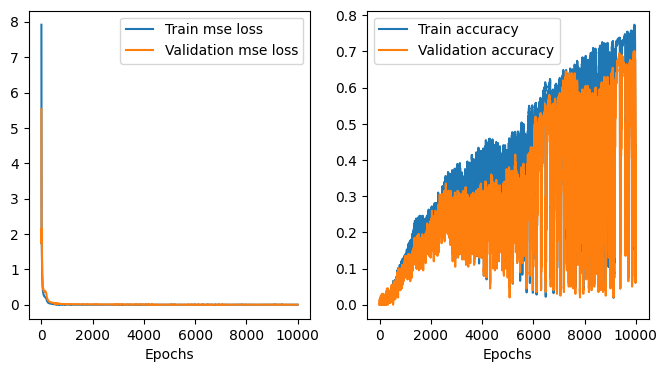

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')
# f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]]**2)
# dataset = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)
# dataset1 = create_dataset(f, n_var=2, train_num=1000, test_num=200, device=device)

# train_ds = TensorDataset(dataset['train_input'], dataset['train_label'])
# val_ds = TensorDataset(dataset['test_input'], dataset['test_label'])
# test_ds = TensorDataset(dataset1['test_input'], dataset1['test_label'])
# train_loader = DataLoader(train_ds, batch_size=16384, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=16384, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=16384, shuffle=False)
model = KAN_FFT([[2,0],[6,2],[1,0]], 12).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)    
loss_fn = torch.nn.MSELoss()

train_loss_history=[]
val_loss_history=[]
train_accuracy_history = []
val_accuracy_history = []

torch.cuda.reset_peak_memory_stats()
st=time()
best_acc = 0
NUM_EPOCHS=10000
for epoch in range(NUM_EPOCHS):
    train_loss, val_loss, train_acc, val_acc = train(model, 
                                                        device, 
                                                        train_loader, 
                                                        val_loader, 
                                                        optimizer, 
                                                        loss_fn, 
                                                        epoch + 1)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        print(f'New best Accuracy : {best_acc:.5f}')
        torch.save(model.state_dict(), 'log/FFt_model_mult.pth')
        
    if val_acc == 1:
        break
print("Training time (sec):",time()-st)
print("Best validation accuracy=",best_acc*100,'%')
plt.clf()
f,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(train_loss_history,label='Train mse loss')
ax[0].plot(val_loss_history,label='Validation mse loss')
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(train_accuracy_history,label='Train accuracy')
ax[1].plot(val_accuracy_history,label='Validation accuracy')
ax[1].set_xlabel("Epochs")
ax[1].legend()
# plt.savefig(log_dir+'/'+'plots.png')


In [ ]:
## Test unseen data
tolerance = 0.01
total_loss_test = 0

model = KAN_FFT([[2,0],[5,2],[1,0]], 12).to(device)  # same model class as training
model.load_state_dict(torch.load(log_dir+'log/FFt_model_mult.pth')) # Load best accuracy model
model.eval()  # set to evaluation mode if doing inference

with torch.no_grad():
    for _, (x,y) in enumerate(test_loader):
        x,y = x.to(device),y.to(device)
        output = model(x)
        loss = loss_fn(output, y)      
        total_loss_test += loss.item()
    
        test_accuracy_tol = torch.mean((torch.abs(output - y) < tolerance).float())
    print(f"Test Loss: {total_loss_test:.4f} | Test Acc (tolerance 0.01): {test_accuracy_tol*100:.2f}% ")
    

Test Loss: 3.8704 | Test Acc: 1.00% 
